[Pythonで学ぶ統計的機械学習 - 密度推定](https://github.com/kanamori-takafumi/book_StatMachineLearn_with_Python/blob/master/ch14densityratio.ipynb) を試してみる

密度比の推定

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import norm
from scipy.spatial import distance
from sklearn.metrics.pairwise import rbf_kernel
import seaborn as sns
import pandas as pd

In [32]:
# データ設定 
n, m = 100, 200
nu_mean, nu_sd = -0.5, 1
a_mean,  a_sd = 1, 0.8
newdat = np.linspace(-4,4,500).reshape(500,1)  # 予測点
tnu =  norm.pdf(newdat, nu_mean, nu_sd)            # 確率密度の計算
tde = (norm.pdf(newdat, a_mean, a_sd)+tnu)/2
tw = tnu/tde                                   # 予測点上での真の密度比

In [33]:
# データ生成
nu = np.random.normal(loc=nu_mean, scale=nu_sd, size=n).reshape(n,1)
ma = np.random.binomial(m,0.5); mb = m-ma
de = np.r_[np.random.normal(loc=nu_mean,scale=nu_sd,size=ma).reshape(ma,1), np.random.normal(loc=a_mean, scale=a_sd, size=mb).reshape(mb,1)]

In [2]:
class kernelDensityRatio:
    """
    kernel density-ratio estimator using Gaussian kernel
    gamma: bandwidth of Gaussian kernel
    lam: regularizaiton parameter
    """
    def __init__(self, gamma=None, lam=None):
        self.gamma = gamma             # カーネル幅
        self.lam = lam                 # 正則化パラメータ
        
    def fit(self, de, nu):             # 密度比推定
        if self.gamma is None:
            ma = nu.shape[0] + de.shape[0]
            idx = np.random.choice(ma,round(ma/2))
            self.gamma = (1/np.median(distance.pdist(np.r_[nu,de][idx,:])))**2
        if self.lam is None:
            self.lam = (min(nu.shape[0], de.shape[0]))**(-0.9)
        gamma = self.gamma; lam = self.lam
        n = de.shape[0]
        # グラム行列の計算
        Kdd = rbf_kernel(de, gamma=gamma)
        Kdn = rbf_kernel(de, nu, gamma=gamma)
        # 係数の推定
        Amat = Kdd + n*lam*np.identity(n)
        bvec = -np.mean(Kdn,1)/lam
        self.alpha = np.linalg.solve(Amat, bvec)
        self.de, self.nu = de, nu
        return self
    
    def predict(self, x):               # 予測点 x での密度比の値
        Wde =  np.dot(rbf_kernel(x, self.de, gamma=self.gamma), self.alpha)
        Wnu = np.mean(rbf_kernel(x, self.nu, gamma=self.gamma),1)/self.lam
        return np.maximum(Wde + Wnu,0)


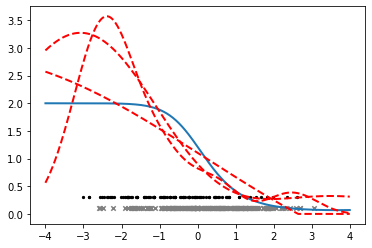

In [34]:
plt.plot(newdat,tw,lw=2)            # 真の密度比関数のプロット
# データ点のプロット
plt.scatter(nu.reshape(n,),np.repeat(0.3,n),marker='.',c='black',s=20)
plt.scatter(de.reshape(m,),np.repeat(0.1,m),marker='x',c='gray',s=20)
# 以下のカーネル幅で推定
gammas = np.array([0.01, 0.1, 1])
for g in gammas:
    dr = kernelDensityRatio(gamma=g)
    dr.fit(de,nu)                   # データへのフィッティング
    drp = dr.predict(newdat)        # 密度比の予測値
    plt.plot(newdat,drp, c='red',linestyle='dashed',lw=2)  # プロット
plt.show()

密度比推定のための交差検証法

In [15]:
from scipy.spatial import distance        # distanceの計算
cvk = 5                                                      # 交差検証法のK
n, m = nu.shape[0], de.shape[0]          # データ数
# カーネル幅パラメータの候補を生成
idx = np.random.choice(n+m,round((n+m)/2))
gammas = 1/np.percentile(distance.pdist(np.r_[nu,de][idx,:]),[1,99])**2
gammas = np.logspace(np.log10(gammas.min()/100), np.log10(gammas.max()*100),10)
# 正則化パラメータ lambda の候補を生成 
lams = np.array([(min(n,m))**(-0.9)])
# モデルパラメータの候補
modelpars = np.array([(x,y) for x in gammas for y in lams])

In [16]:
# それぞれのデータを5グループに分ける
inu = np.repeat(np.arange(cvk),np.ceil(n/cvk))
inu = inu[np.random.choice(n,n,replace=False)]
ide = np.repeat(np.arange(cvk),np.ceil(m/cvk))
ide = ide[np.random.choice(m,m,replace=False)]
cvloss = []
for gamma, lam in modelpars:
    tcvloss = []
    for k in np.arange(cvk):
        # トレーニングデータ
        trnu, trde = nu[inu!=k,:], de[ide!=k,:]
        # テストデータ
        tenu, tede = nu[inu==k,:], de[ide==k,:]
        # 指定されたモデルパラメータで密度比を推定
        kdr =kernelDensityRatio(gamma=gamma, lam=lam)
        kdr.fit(trde, trnu)                             # 推定
        wde = kdr.predict(tede)                         # de上で予測
        wnu = kdr.predict(tenu)                         # nu上で予測
        tcvloss.append(np.mean(wde**2)/2-np.mean(wnu))  # 二乗損失
    cvloss.append(np.mean(tcvloss))
# 最適なモデルパラメータ
optgamma,optlam = modelpars[np.argmin(cvloss),:]
optgamma,optlam

(0.04459142905354613, 0.015848931924611134)

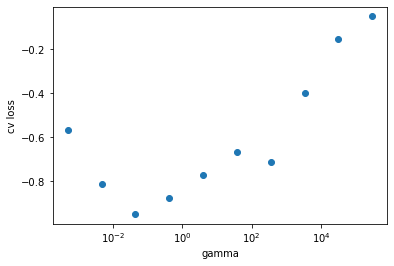

In [17]:
plt.xscale('log'); plt.xlabel('gamma'); plt.ylabel('cv loss')
plt.scatter(gammas, cvloss)
plt.show()

In [18]:
# 密度比の推定
kdr =kernelDensityRatio(gamma=optgamma, lam=optlam)
kdr.fit(de,nu)
kdr.predict(newdat)

array([2.96207494e+00, 2.96571084e+00, 2.96926571e+00, 2.97273911e+00,
       2.97613061e+00, 2.97943976e+00, 2.98266614e+00, 2.98580933e+00,
       2.98886889e+00, 2.99184442e+00, 2.99473551e+00, 2.99754176e+00,
       3.00026276e+00, 3.00289812e+00, 3.00544746e+00, 3.00791040e+00,
       3.01028654e+00, 3.01257554e+00, 3.01477701e+00, 3.01689061e+00,
       3.01891598e+00, 3.02085276e+00, 3.02270063e+00, 3.02445924e+00,
       3.02612826e+00, 3.02770738e+00, 3.02919627e+00, 3.03059462e+00,
       3.03190214e+00, 3.03311851e+00, 3.03424345e+00, 3.03527668e+00,
       3.03621791e+00, 3.03706687e+00, 3.03782330e+00, 3.03848694e+00,
       3.03905753e+00, 3.03953483e+00, 3.03991860e+00, 3.04020861e+00,
       3.04040463e+00, 3.04050644e+00, 3.04051384e+00, 3.04042662e+00,
       3.04024457e+00, 3.03996752e+00, 3.03959528e+00, 3.03912766e+00,
       3.03856451e+00, 3.03790566e+00, 3.03715095e+00, 3.03630024e+00,
       3.03535339e+00, 3.03431027e+00, 3.03317075e+00, 3.03193472e+00,
      

共変量シフトの下での回帰分析

In [19]:
# 真の回帰関数 
def f(x): 
    return (x+2)*(x-3)*x
# データ設定
ntr, mtr, sdtr   = 100, -1.4, 0.7
nte, mte, sdte = 100,  0.8, 0.8
# トレーニングデータ生成
xtr = np.random.normal(loc=mtr, scale=sdtr, size=ntr).reshape(ntr,1)
ytr = f(xtr) + np.random.normal(scale=2, size=ntr).reshape(ntr,1)
# テストデータ生成
xte = np.random.normal(loc=mte, scale=sdte, size=nte).reshape(nte,1)
yte = f(xte) + np.random.normal(scale=2, size=nte).reshape(nte,1)

In [20]:
# トレーニングデータ点上での密度比を推定
kdr = kernelDensityRatio()
kdr.fit(xtr,xte)
pw = kdr.predict(xtr)
# 重み付き最小二乗法で回帰パラメータを推定
W = np.sqrt(np.diag(pw))
X =  sm.add_constant(xtr)
WX = np.dot(W,X); WY = np.dot(W, ytr)
estTheta = np.linalg.solve(np.dot(WX.T,WX), np.dot(WX.T,WY))
estTheta

array([[-0.60668938],
       [-2.89346929]])

二標本検定

In [21]:
from sklearn.preprocessing import scale
from sklearn import datasets
d = datasets.load_breast_cancer()        # データ読込み
de = d.data[d.target==0]; de = scale(de) # スケーリング
nu = d.data[d.target==1]; nu = scale(nu) # スケーリング

In [22]:
kdr =kernelDensityRatio() 
kdr.fit(de,nu)                               # 密度比の推定
L1distEst = np.mean(abs(1-kdr.predict(de)))  # L1距離の推定値
nperm = 10000                                # 並べ替え検定の繰り返し数
nde, nnu = de.shape[0], nu.shape[0]
dall = np.r_[de,nu]
permL1dist = []
for itr in np.arange(nperm):
    idx = np.random.choice(nde+nnu,nde,replace=False)   # データの並べ替え
    perm_de = dall[idx,:]
    perm_nu = np.delete(dall,idx,0)
    pdr =kernelDensityRatio()
    pdr.fit(perm_de, perm_nu)            # 並べ替えデータに対する密度比の推定
    permL1dist.append(np.mean(abs(1-pdr.predict(perm_de)))) # L1距離の推定
np.mean(L1distEst < np.array(permL1dist))          # 並べ替え検定による p値

0.0497

`banana` データセットでの共変量シフト問題

In [3]:
import os, glob, time, copy, random, zipfile

In [4]:
os.listdir('./data/banana')

['test', 'train']

In [5]:
# Train_dir, Test_dir
base_dir = './data/banana'
train_dir = base_dir + '/train'
test_dir  = base_dir + '/test'

# Check File Name
os.listdir(train_dir)[:5]

['banana_train_data_1.asc',
 'banana_train_data_10.asc',
 'banana_train_data_100.asc',
 'banana_train_data_11.asc',
 'banana_train_data_12.asc']

In [27]:
# FilePath List
train_data_list = glob.glob(os.path.join(train_dir , 'banana_train_data_*.asc'))
train_label_list = glob.glob(os.path.join(train_dir , 'banana_train_labels_*.asc'))
test_data_list = glob.glob(os.path.join(test_dir, '*banana_test_data_*.asc'))
test_label_list = glob.glob(os.path.join(test_dir, '*banana_test_labels_*.asc'))

train_data_list = [string.replace('\\', '/') for string in train_data_list]
train_label_list = [string.replace('\\', '/') for string in train_label_list]
test_data_list = [string.replace('\\', '/') for string in test_data_list]
test_label_list = [string.replace('\\', '/') for string in test_label_list]

print(train_data_list)

['./data/banana/train/banana_train_data_1.asc', './data/banana/train/banana_train_data_10.asc', './data/banana/train/banana_train_data_100.asc', './data/banana/train/banana_train_data_11.asc', './data/banana/train/banana_train_data_12.asc', './data/banana/train/banana_train_data_13.asc', './data/banana/train/banana_train_data_14.asc', './data/banana/train/banana_train_data_15.asc', './data/banana/train/banana_train_data_16.asc', './data/banana/train/banana_train_data_17.asc', './data/banana/train/banana_train_data_18.asc', './data/banana/train/banana_train_data_19.asc', './data/banana/train/banana_train_data_2.asc', './data/banana/train/banana_train_data_20.asc', './data/banana/train/banana_train_data_21.asc', './data/banana/train/banana_train_data_22.asc', './data/banana/train/banana_train_data_23.asc', './data/banana/train/banana_train_data_24.asc', './data/banana/train/banana_train_data_25.asc', './data/banana/train/banana_train_data_26.asc', './data/banana/train/banana_train_data_2

In [30]:
# 学習データ読み込み
f = open(train_data_list[0])
X_train = [s.lstrip() for s in f.read().split('\n')]
X_train = [ list(map(float, list(filter(lambda a: a != '', s.split(' '))))) for s in X_train ]
X_train = [ x for x in X_train if len(x) == 2 ]
print([i for i,x in enumerate(X_train) if len(x) != 2])
X_train = np.array(X_train, dtype=float)
print(X_train.shape)
print(X_train.dtype)
f.close()

f = open(train_label_list[0])
y_train = [ s.lstrip() for s in f.read().split('\n') ]
y_train = [ list(map(float, list(filter(lambda a: a != '', s.split(' '))))) for s in y_train ]
y_train = [ x for x in y_train if len(x) == 1 ]
print([i for i,x in enumerate(y_train) if len(x) != 1])
y_train = np.array(y_train, dtype=float)
print(y_train.shape)
print(y_train.dtype)
f.close()

[]
(400, 2)
float64
[]
(400, 1)
float64


In [35]:
# テストデータ
f = open(test_data_list[0])
X_test = [s.lstrip() for s in f.read().split('\n')]
X_test = [ list(map(float, list(filter(lambda a: a != '', s.split(' '))))) for s in X_test ]
X_test = [ x for x in X_test if len(x) == 2 ]
print([i for i,x in enumerate(X_test) if len(x) != 2])
X_test = np.array(X_test, dtype=float)
print(X_test.shape)
print(X_test.dtype)
f.close()

f = open(test_label_list[0])
y_test = [ s.lstrip() for s in f.read().split('\n') ]
y_test = [ list(map(float, list(filter(lambda a: a != '', s.split(' '))))) for s in y_test ]
y_test = [ x for x in y_test if len(x) == 1 ]
print([i for i,x in enumerate(y_test) if len(x) != 1])
y_test = np.array(y_test, dtype=float)
print(y_test.shape)
print(y_test.dtype)
f.close()

[]
(4900, 2)
float64
[]
(4900, 1)
float64


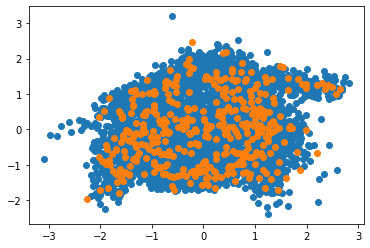

In [41]:
plt.scatter(X_test[:,0], X_test[:,1])
plt.scatter(X_train[:,0],X_train[:,1])
plt.show()

In [31]:
# # トレーニングデータ点上での密度比を推定
# kdr = kernelDensityRatio()
# kdr.fit(X_train, y_train)
# pw = kdr.predict(X_train)
# # 重み付き最小二乗法で回帰パラメータを推定
# W = np.sqrt(np.diag(pw))
# X =  sm.add_constant(X_train)
# WX = np.dot(W,X); WY = np.dot(W, y_train)
# estTheta = np.linalg.solve(np.dot(WX.T,WX), np.dot(WX.T,WY))
# estTheta

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 1 and the array at index 1 has size 2

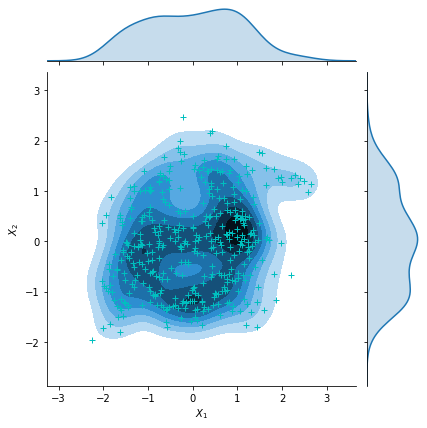

In [55]:
# 学習データのカーネル密度推定
x = X_train[:,0]; y = X_train[:,1]
df = pd.DataFrame(data=X_train, columns=['x1', 'x2'], dtype='float')
g = sns.jointplot(x="x1",y="x2",data=df, kind="kde")
g.plot_joint(plt.scatter, c="c", s=30, linewidth=1, marker="+")
g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels("$X_1$", "$X_2$")

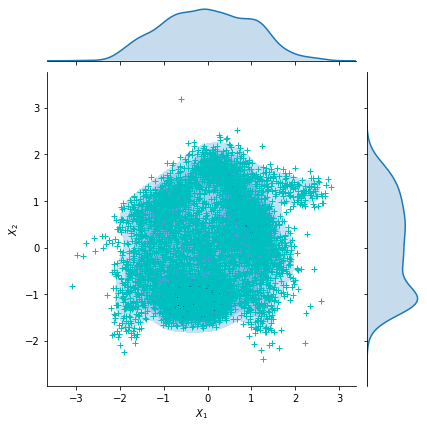

In [56]:
# テストデータのカーネル密度推定
df = pd.DataFrame(data=X_test, columns=['x1', 'x2'], dtype='float')
g = sns.jointplot(x="x1",y="x2",data=df, kind="kde")
g.plot_joint(plt.scatter, c="c", s=30, linewidth=1, marker="+")
g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels("$X_1$", "$X_2$")
